Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs

# Sample from latent Lorenz attractor:


In [2]:
Time = 500
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_500.mat")
y_data = datax["spike30_sim_500"] 
traj = scipy.io.loadmat("trj30_sim_500.mat")
traj = traj["trj30_sim_500"]

(500, 30)


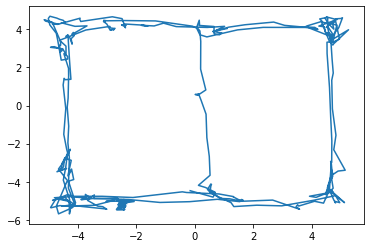

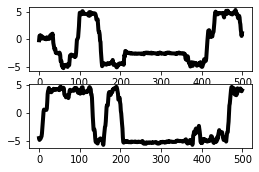

In [3]:
factor_dim = 2

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)

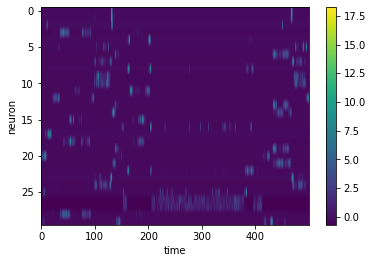

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((output))
#print(dataset)
#dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        #self.dense_output = tf.keras.layers.Dense(64, activation='relu')
        self.dense_output2 = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        #xo = self.dense_output(x)
        xo = self.dense_output2(x)
        #xo = 5*tf.exp(tf.nn.tanh(self.dense_output2(xo)))
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 64
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=32,
                             num_gru_unit=32,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=7e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,10)

In [ ]:
epochs = 6500

for i,kl_ in enumerate(KL_penalty):
    print(kl_,i)
    if i > 0:
        break
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,),'i',i)

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                #print("loss",loss,"kl",sum(vae.losses))
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

0.0 0
Start of epoch 0 i 0
step 0: mean loss = 1.0000296
Start of epoch 1 i 0
step 0: mean loss = 1.0004433
Start of epoch 2 i 0
step 0: mean loss = 1.0003675
Start of epoch 3 i 0
step 0: mean loss = 1.0003146
Start of epoch 4 i 0
step 0: mean loss = 1.0003957
Start of epoch 5 i 0
step 0: mean loss = 1.0003711
Start of epoch 6 i 0
step 0: mean loss = 1.0003167
Start of epoch 7 i 0
step 0: mean loss = 1.0002617
Start of epoch 8 i 0
step 0: mean loss = 1.000218
Start of epoch 9 i 0
step 0: mean loss = 1.0001777
Start of epoch 10 i 0
step 0: mean loss = 1.0001626
Start of epoch 11 i 0
step 0: mean loss = 1.0001348
Start of epoch 12 i 0
step 0: mean loss = 1.0001118
Start of epoch 13 i 0
step 0: mean loss = 1.000084
Start of epoch 14 i 0
step 0: mean loss = 1.0000376
Start of epoch 15 i 0
step 0: mean loss = 1.0000514
Start of epoch 16 i 0
step 0: mean loss = 1.000016
Start of epoch 17 i 0
step 0: mean loss = 0.99993485
Start of epoch 18 i 0
step 0: mean loss = 0.9998816
Start of epoch 19 

step 0: mean loss = 0.97195554
Start of epoch 157 i 0
step 0: mean loss = 0.9718458
Start of epoch 158 i 0
step 0: mean loss = 0.97173774
Start of epoch 159 i 0
step 0: mean loss = 0.97163
Start of epoch 160 i 0
step 0: mean loss = 0.97152483
Start of epoch 161 i 0
step 0: mean loss = 0.9714195
Start of epoch 162 i 0
step 0: mean loss = 0.97131544
Start of epoch 163 i 0
step 0: mean loss = 0.97121334
Start of epoch 164 i 0
step 0: mean loss = 0.97111076
Start of epoch 165 i 0
step 0: mean loss = 0.97101
Start of epoch 166 i 0
step 0: mean loss = 0.9709098
Start of epoch 167 i 0
step 0: mean loss = 0.97081083
Start of epoch 168 i 0
step 0: mean loss = 0.97071254
Start of epoch 169 i 0
step 0: mean loss = 0.97061497
Start of epoch 170 i 0
step 0: mean loss = 0.9705189
Start of epoch 171 i 0
step 0: mean loss = 0.9704232
Start of epoch 172 i 0
step 0: mean loss = 0.9703287
Start of epoch 173 i 0
step 0: mean loss = 0.970235
Start of epoch 174 i 0
step 0: mean loss = 0.9701419
Start of epo

step 0: mean loss = 0.96235377
Start of epoch 311 i 0
step 0: mean loss = 0.9622905
Start of epoch 312 i 0
step 0: mean loss = 0.96222734
Start of epoch 313 i 0
step 0: mean loss = 0.96216434
Start of epoch 314 i 0
step 0: mean loss = 0.96210134
Start of epoch 315 i 0
step 0: mean loss = 0.96203846
Start of epoch 316 i 0
step 0: mean loss = 0.9619759
Start of epoch 317 i 0
step 0: mean loss = 0.96191347
Start of epoch 318 i 0
step 0: mean loss = 0.9618513
Start of epoch 319 i 0
step 0: mean loss = 0.9617893
Start of epoch 320 i 0
step 0: mean loss = 0.9617276
Start of epoch 321 i 0
step 0: mean loss = 0.9616662
Start of epoch 322 i 0
step 0: mean loss = 0.96160513
Start of epoch 323 i 0
step 0: mean loss = 0.96154416
Start of epoch 324 i 0
step 0: mean loss = 0.96148354
Start of epoch 325 i 0
step 0: mean loss = 0.9614233
Start of epoch 326 i 0
step 0: mean loss = 0.96136326
Start of epoch 327 i 0
step 0: mean loss = 0.96130353
Start of epoch 328 i 0
step 0: mean loss = 0.96124405
Star

step 0: mean loss = 0.95542824
Start of epoch 465 i 0
step 0: mean loss = 0.95539784
Start of epoch 466 i 0
step 0: mean loss = 0.9553676
Start of epoch 467 i 0
step 0: mean loss = 0.95533746
Start of epoch 468 i 0
step 0: mean loss = 0.9553075
Start of epoch 469 i 0
step 0: mean loss = 0.9552776
Start of epoch 470 i 0
step 0: mean loss = 0.9552479
Start of epoch 471 i 0
step 0: mean loss = 0.9552182
Start of epoch 472 i 0
step 0: mean loss = 0.9551887
Start of epoch 473 i 0
step 0: mean loss = 0.95515925
Start of epoch 474 i 0
step 0: mean loss = 0.95513
Start of epoch 475 i 0
step 0: mean loss = 0.9551008
Start of epoch 476 i 0
step 0: mean loss = 0.95507175
Start of epoch 477 i 0
step 0: mean loss = 0.95504284
Start of epoch 478 i 0
step 0: mean loss = 0.95501405
Start of epoch 479 i 0
step 0: mean loss = 0.9549854
Start of epoch 480 i 0
step 0: mean loss = 0.95495677
Start of epoch 481 i 0
step 0: mean loss = 0.95492834
Start of epoch 482 i 0
step 0: mean loss = 0.95489997
Start of

step 0: mean loss = 0.95189553
Start of epoch 619 i 0
step 0: mean loss = 0.9518783
Start of epoch 620 i 0
step 0: mean loss = 0.95186114
Start of epoch 621 i 0
step 0: mean loss = 0.95184404
Start of epoch 622 i 0
step 0: mean loss = 0.951827
Start of epoch 623 i 0
step 0: mean loss = 0.95181
Start of epoch 624 i 0
step 0: mean loss = 0.9517931
Start of epoch 625 i 0
step 0: mean loss = 0.9517762
Start of epoch 626 i 0
step 0: mean loss = 0.95175934
Start of epoch 627 i 0
step 0: mean loss = 0.9517426
Start of epoch 628 i 0
step 0: mean loss = 0.95172584
Start of epoch 629 i 0
step 0: mean loss = 0.95170915
Start of epoch 630 i 0
step 0: mean loss = 0.9516926
Start of epoch 631 i 0
step 0: mean loss = 0.951676
Start of epoch 632 i 0
step 0: mean loss = 0.9516595
Start of epoch 633 i 0
step 0: mean loss = 0.95164305
Start of epoch 634 i 0
step 0: mean loss = 0.9516266
Start of epoch 635 i 0
step 0: mean loss = 0.95161027
Start of epoch 636 i 0
step 0: mean loss = 0.95159394
Start of ep

step 0: mean loss = 0.94976926
Start of epoch 773 i 0
step 0: mean loss = 0.94975823
Start of epoch 774 i 0
step 0: mean loss = 0.9497472
Start of epoch 775 i 0
step 0: mean loss = 0.94973624
Start of epoch 776 i 0
step 0: mean loss = 0.9497253
Start of epoch 777 i 0
step 0: mean loss = 0.9497143
Start of epoch 778 i 0
step 0: mean loss = 0.94970345
Start of epoch 779 i 0
step 0: mean loss = 0.94969255
Start of epoch 780 i 0
step 0: mean loss = 0.9496817
Start of epoch 781 i 0
step 0: mean loss = 0.9496709
Start of epoch 782 i 0
step 0: mean loss = 0.9496601
Start of epoch 783 i 0
step 0: mean loss = 0.94964933
Start of epoch 784 i 0
step 0: mean loss = 0.9496386
Start of epoch 785 i 0
step 0: mean loss = 0.9496279
Start of epoch 786 i 0
step 0: mean loss = 0.9496172
Start of epoch 787 i 0
step 0: mean loss = 0.9496066
Start of epoch 788 i 0
step 0: mean loss = 0.9495959
Start of epoch 789 i 0
step 0: mean loss = 0.9495853
Start of epoch 790 i 0
step 0: mean loss = 0.94957477
Start of 

step 0: mean loss = 0.94834864
Start of epoch 927 i 0
step 0: mean loss = 0.94834095
Start of epoch 928 i 0
step 0: mean loss = 0.9483333
Start of epoch 929 i 0
step 0: mean loss = 0.9483257
Start of epoch 930 i 0
step 0: mean loss = 0.94831795
Start of epoch 931 i 0
step 0: mean loss = 0.9483104
Start of epoch 932 i 0
step 0: mean loss = 0.94830275
Start of epoch 933 i 0
step 0: mean loss = 0.9482952
Start of epoch 934 i 0
step 0: mean loss = 0.94828755
Start of epoch 935 i 0
step 0: mean loss = 0.94828004
Start of epoch 936 i 0
step 0: mean loss = 0.9482724
Start of epoch 937 i 0
step 0: mean loss = 0.9482649
Start of epoch 938 i 0
step 0: mean loss = 0.9482573
Start of epoch 939 i 0
step 0: mean loss = 0.9482499
Start of epoch 940 i 0
step 0: mean loss = 0.9482423
Start of epoch 941 i 0
step 0: mean loss = 0.94823486
Start of epoch 942 i 0
step 0: mean loss = 0.94822735
Start of epoch 943 i 0
step 0: mean loss = 0.94821995
Start of epoch 944 i 0
step 0: mean loss = 0.94821256
Start 

step 0: mean loss = 0.9473341
Start of epoch 1080 i 0
step 0: mean loss = 0.9473284
Start of epoch 1081 i 0
step 0: mean loss = 0.9473227
Start of epoch 1082 i 0
step 0: mean loss = 0.947317
Start of epoch 1083 i 0
step 0: mean loss = 0.94731134
Start of epoch 1084 i 0
step 0: mean loss = 0.9473057
Start of epoch 1085 i 0
step 0: mean loss = 0.9473005
Start of epoch 1086 i 0
step 0: mean loss = 0.9472952
Start of epoch 1087 i 0
step 0: mean loss = 0.94728976
Start of epoch 1088 i 0
step 0: mean loss = 0.9472846
Start of epoch 1089 i 0
step 0: mean loss = 0.94727916
Start of epoch 1090 i 0
step 0: mean loss = 0.9472739
Start of epoch 1091 i 0
step 0: mean loss = 0.94726855
Start of epoch 1092 i 0
step 0: mean loss = 0.94726306
Start of epoch 1093 i 0
step 0: mean loss = 0.9472577
Start of epoch 1094 i 0
step 0: mean loss = 0.9472523
Start of epoch 1095 i 0
step 0: mean loss = 0.9472469
Start of epoch 1096 i 0
step 0: mean loss = 0.9472415
Start of epoch 1097 i 0
step 0: mean loss = 0.94

step 0: mean loss = 0.9465813
Start of epoch 1231 i 0
step 0: mean loss = 0.9465769
Start of epoch 1232 i 0
step 0: mean loss = 0.9465725
Start of epoch 1233 i 0
step 0: mean loss = 0.94656813
Start of epoch 1234 i 0
step 0: mean loss = 0.9465637
Start of epoch 1235 i 0
step 0: mean loss = 0.94655937
Start of epoch 1236 i 0
step 0: mean loss = 0.946555
Start of epoch 1237 i 0
step 0: mean loss = 0.94655067
Start of epoch 1238 i 0
step 0: mean loss = 0.9465463
Start of epoch 1239 i 0
step 0: mean loss = 0.94654197
Start of epoch 1240 i 0
step 0: mean loss = 0.9465376
Start of epoch 1241 i 0
step 0: mean loss = 0.9465333
Start of epoch 1242 i 0
step 0: mean loss = 0.946529
Start of epoch 1243 i 0
step 0: mean loss = 0.9465247
Start of epoch 1244 i 0
step 0: mean loss = 0.9465204
Start of epoch 1245 i 0
step 0: mean loss = 0.94651604
Start of epoch 1246 i 0
step 0: mean loss = 0.94651175
Start of epoch 1247 i 0
step 0: mean loss = 0.94650745
Start of epoch 1248 i 0
step 0: mean loss = 0.9

step 0: mean loss = 0.9459892
Start of epoch 1382 i 0
step 0: mean loss = 0.9459857
Start of epoch 1383 i 0
step 0: mean loss = 0.9459822
Start of epoch 1384 i 0
step 0: mean loss = 0.9459787
Start of epoch 1385 i 0
step 0: mean loss = 0.94597524
Start of epoch 1386 i 0
step 0: mean loss = 0.9459718
Start of epoch 1387 i 0
step 0: mean loss = 0.94596833
Start of epoch 1388 i 0
step 0: mean loss = 0.9459649
Start of epoch 1389 i 0
step 0: mean loss = 0.9459614
Start of epoch 1390 i 0
step 0: mean loss = 0.94595796
Start of epoch 1391 i 0
step 0: mean loss = 0.9459545
Start of epoch 1392 i 0
step 0: mean loss = 0.94595104
Start of epoch 1393 i 0
step 0: mean loss = 0.94594765
Start of epoch 1394 i 0
step 0: mean loss = 0.9459442
Start of epoch 1395 i 0
step 0: mean loss = 0.9459408
Start of epoch 1396 i 0
step 0: mean loss = 0.94593734
Start of epoch 1397 i 0
step 0: mean loss = 0.94593394
Start of epoch 1398 i 0
step 0: mean loss = 0.94593054
Start of epoch 1399 i 0
step 0: mean loss = 

step 0: mean loss = 0.9455137
Start of epoch 1533 i 0
step 0: mean loss = 0.94551086
Start of epoch 1534 i 0
step 0: mean loss = 0.94550806
Start of epoch 1535 i 0
step 0: mean loss = 0.9455052
Start of epoch 1536 i 0
step 0: mean loss = 0.9455024
Start of epoch 1537 i 0
step 0: mean loss = 0.9454996
Start of epoch 1538 i 0
step 0: mean loss = 0.94549674
Start of epoch 1539 i 0
step 0: mean loss = 0.94549394
Start of epoch 1540 i 0
step 0: mean loss = 0.94549114
Start of epoch 1541 i 0
step 0: mean loss = 0.94548833
Start of epoch 1542 i 0
step 0: mean loss = 0.94548553
Start of epoch 1543 i 0
step 0: mean loss = 0.94548273
Start of epoch 1544 i 0
step 0: mean loss = 0.9454799
Start of epoch 1545 i 0
step 0: mean loss = 0.9454771
Start of epoch 1546 i 0
step 0: mean loss = 0.9454743
Start of epoch 1547 i 0
step 0: mean loss = 0.9454715
Start of epoch 1548 i 0
step 0: mean loss = 0.9454688
Start of epoch 1549 i 0
step 0: mean loss = 0.945466
Start of epoch 1550 i 0
step 0: mean loss = 0

step 0: mean loss = 0.94529384
Start of epoch 1684 i 0
step 0: mean loss = 0.94528
Start of epoch 1685 i 0
step 0: mean loss = 0.94526625
Start of epoch 1686 i 0
step 0: mean loss = 0.94525224
Start of epoch 1687 i 0
step 0: mean loss = 0.9452381
Start of epoch 1688 i 0
step 0: mean loss = 0.94522375
Start of epoch 1689 i 0
step 0: mean loss = 0.9452092
Start of epoch 1690 i 0
step 0: mean loss = 0.9451946
Start of epoch 1691 i 0
step 0: mean loss = 0.9451799
Start of epoch 1692 i 0
step 0: mean loss = 0.94516504
Start of epoch 1693 i 0
step 0: mean loss = 0.94515
Start of epoch 1694 i 0
step 0: mean loss = 0.9451348
Start of epoch 1695 i 0
step 0: mean loss = 0.94511956
Start of epoch 1696 i 0
step 0: mean loss = 0.9451041
Start of epoch 1697 i 0
step 0: mean loss = 0.94508857
Start of epoch 1698 i 0
step 0: mean loss = 0.9450728
Start of epoch 1699 i 0
step 0: mean loss = 0.9450569
Start of epoch 1700 i 0
step 0: mean loss = 0.94504094
Start of epoch 1701 i 0
step 0: mean loss = 0.94

step 0: mean loss = 0.9424457
Start of epoch 1836 i 0
step 0: mean loss = 0.94243073
Start of epoch 1837 i 0
step 0: mean loss = 0.9424154
Start of epoch 1838 i 0
step 0: mean loss = 0.94239974
Start of epoch 1839 i 0
step 0: mean loss = 0.94238406
Start of epoch 1840 i 0
step 0: mean loss = 0.94236845
Start of epoch 1841 i 0
step 0: mean loss = 0.9423528
Start of epoch 1842 i 0
step 0: mean loss = 0.94233686
Start of epoch 1843 i 0
step 0: mean loss = 0.9423208
Start of epoch 1844 i 0
step 0: mean loss = 0.94230485
Start of epoch 1845 i 0
step 0: mean loss = 0.9422889
Start of epoch 1846 i 0
step 0: mean loss = 0.9422728
Start of epoch 1847 i 0
step 0: mean loss = 0.94225657
Start of epoch 1848 i 0
step 0: mean loss = 0.9422404
Start of epoch 1849 i 0
step 0: mean loss = 0.94222426
Start of epoch 1850 i 0
step 0: mean loss = 0.9422081
Start of epoch 1851 i 0
step 0: mean loss = 0.94219196
Start of epoch 1852 i 0
step 0: mean loss = 0.9421757
Start of epoch 1853 i 0
step 0: mean loss =

step 0: mean loss = 0.93981594
Start of epoch 1987 i 0
step 0: mean loss = 0.93979734
Start of epoch 1988 i 0
step 0: mean loss = 0.93977857
Start of epoch 1989 i 0
step 0: mean loss = 0.93975973
Start of epoch 1990 i 0
step 0: mean loss = 0.9397409
Start of epoch 1991 i 0
step 0: mean loss = 0.9397222
Start of epoch 1992 i 0
step 0: mean loss = 0.9397036
Start of epoch 1993 i 0
step 0: mean loss = 0.93968487
Start of epoch 1994 i 0
step 0: mean loss = 0.93966603
Start of epoch 1995 i 0
step 0: mean loss = 0.93964726
Start of epoch 1996 i 0
step 0: mean loss = 0.93962854
Start of epoch 1997 i 0
step 0: mean loss = 0.93960994
Start of epoch 1998 i 0
step 0: mean loss = 0.9395913
Start of epoch 1999 i 0
step 0: mean loss = 0.9395726
Start of epoch 2000 i 0
step 0: mean loss = 0.93955386
Start of epoch 2001 i 0
step 0: mean loss = 0.9395352
Start of epoch 2002 i 0
step 0: mean loss = 0.93951654
Start of epoch 2003 i 0
step 0: mean loss = 0.9394979
Start of epoch 2004 i 0
step 0: mean loss

step 0: mean loss = 0.9371186
Start of epoch 2138 i 0
step 0: mean loss = 0.9371017
Start of epoch 2139 i 0
step 0: mean loss = 0.93708473
Start of epoch 2140 i 0
step 0: mean loss = 0.93706775
Start of epoch 2141 i 0
step 0: mean loss = 0.9370509
Start of epoch 2142 i 0
step 0: mean loss = 0.9370341
Start of epoch 2143 i 0
step 0: mean loss = 0.93701726
Start of epoch 2144 i 0
step 0: mean loss = 0.93700033
Start of epoch 2145 i 0
step 0: mean loss = 0.93698347
Start of epoch 2146 i 0
step 0: mean loss = 0.9369666
Start of epoch 2147 i 0
step 0: mean loss = 0.93694973
Start of epoch 2148 i 0
step 0: mean loss = 0.936933
Start of epoch 2149 i 0
step 0: mean loss = 0.9369163
Start of epoch 2150 i 0
step 0: mean loss = 0.93689954
Start of epoch 2151 i 0
step 0: mean loss = 0.93688273
Start of epoch 2152 i 0
step 0: mean loss = 0.93686587
Start of epoch 2153 i 0
step 0: mean loss = 0.9368491
Start of epoch 2154 i 0
step 0: mean loss = 0.9368324
Start of epoch 2155 i 0


In [ ]:
print(vae(x_batch_train).shape)
for i in range(neuron_num):
    plt.figure()
    plt.plot(vae(x_batch_train)[0,:,i],"r")
    plt.plot(output[0,:,i],'k')
    plt.plot(x_batch_train[0,:,i],'b')

# Evaluate Quality of reconstruction 

In [ ]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')